In [1]:

import os
import tensorflow as tf
from transformers import TFGPT2Model

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import re

In [2]:
# execute if gpt_ckpt is not exist
# import wget
# import zipfile

# wget.download('https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/releases/download/v1.0/gpt_ckpt.zip')

# with zipfile.ZipFile('gpt_ckpt.zip') as z:
#     z.extractall()

In [3]:

# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [4]:

SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

In [5]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [6]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
VALID_SPLIT = 0.2
SENT_MAX_LEN = 128
CLASSIFIER_TYPE = "j_p"
#각 mbti type에 따라 변화 시킬것 e_i, n_s, f_t, j_p로 바꾸어주면 됌

DATA_IN_PATH = './mbti_data_in'
DATA_OUT_PATH = "./mbti_data_out"

In [7]:
# 데이터 전처리 준비

DATA_PATH = os.path.join(DATA_IN_PATH ,f"{CLASSIFIER_TYPE}_data.csv")

data = pd.read_csv(DATA_PATH, header = 0, delimiter = ',')
data = data.dropna()

#print(data)
print("Total # dataset: {}".format(len(data)))

Total # dataset: 27918


In [8]:
data.head()

,Unnamed: 0,articleid,mbti,title,content,menu_id,mbti_label,e_i,n_s,f_t,j_p
0,4393,509726,enfp,엔티제 진짜 노빠꾸네요ㅎㅎ,당황스러울 정도입니다 쉬는 날은 당연히 제가 놀아줄거라는 자신감두요어떻게 하다보니 ...,12,1,1,1,1,0
1,20380,425780,enfj,다들 사람 상대로 답답해 죽겠다고 느끼시나요?,전 진짜 없는거 같아요 돌아보니 다른 사람을 보고 측은하거나 왜저러지라고는 생각해도...,14,0,1,1,1,1
2,3927,351011,infp,오늘 인티제에게 고백을 하게 됐는데요,결과만 말씀드리자면 친구 관계로 남기로 했습니다 물론 잠깐 아쉬운 마음도 들었지만 ...,12,9,0,1,1,0
3,36114,172543,enfp,infp 4번분이랑 잘 안맞네요,저는 enfp 고 회사동료였던 그분은 infp4에요 성격이 잘 안맞기로 최고봉인것 ...,18,1,1,1,1,0
4,22616,93279,enfj,카메라를 샀습니다,사실은 이리저리 취미를 찾다가 말도 안되게 여행자금으로 가지고 있던 돈을 그만 카메...,14,0,1,1,1,1


In [9]:
# 텍스트 전처리

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

In [10]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=1234)

#밑에 바꿔볼것

In [11]:
train_data.head()
test_data.head()

,Unnamed: 0,articleid,mbti,title,content,menu_id,mbti_label,e_i,n_s,f_t,j_p
11142,41825,281699,enfp,동네친구 참 무섭네요ㅋㅋㅋㅋㅋㅋ,초중고 다녔던 지역에서 다른지역으로 3년정도 살았거든요그래서 다시 이쪽 지역으로 왔...,18,1,1,1,1,0
27004,9862,484473,entp,도대체 INFJ는 왜이리 ENTP을 좋아할까요? (엔팁 싫어하는 인프제도 찾아요),제 친구가 저를 유독 좋아하는데요 얘 왜이래 싶을정도로요 알고보니 친구는 infj였...,101,3,1,1,0,0
13019,22605,95167,enfj,우와...,전 솔직히 MBTI라는 걸 그냥 몇가지 정보만 아는 정도 였거든요 그런데 이번에 학...,14,0,1,1,1,1
4273,41728,288074,infp,(여우)<-바보,내일 섭센 갈 정도로 사고친건 아닌데 그냥 업글 겸 공초 부탁드리러 가려고요 역시 ...,18,9,0,1,1,0
292,7926,357941,infp,주인공에 엄청 몰입하시는 분들 있나요?,드라마 영화나 특히 소설 읽을 때 내가 주인공이 되고 싶고 괜히 대사 한 번 연기하...,101,9,0,1,1,0


In [12]:

# train_data = train_data[:50] # for test

train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['content',CLASSIFIER_TYPE ]].values:
    train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

    tokens = [vocab[vocab.bos_token]]  
    tokens += pad_sequences([train_tokenized_text], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    train_data_sents.append(tokens)
    train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

In [13]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()
        
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [14]:
BASE_MODEL_PATH = './gpt_ckpt'
with tf.device('/GPU:7'):
    cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

All model checkpoint weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the model checkpoint at ./gpt_ckpt.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
#f1-score, AUC-ROC, accuracy
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [16]:
model_name = f"tf2_gpt2_mbti_{CLASSIFIER_TYPE}_final"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.00001, patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
with tf.device('/GPU:7'):
    history = cls_model.fit(train_data_sents, train_data_labels, 
                            epochs=NUM_EPOCHS, 
                            batch_size=BATCH_SIZE,
                            validation_split=VALID_SPLIT, 
                            callbacks=[earlystop_callback, cp_callback])

./mbti_data_out/tf2_gpt2_mbti_j_p_final -- Folder create complete 

Epoch 1/10
1117/1117 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5216
Epoch 00001: val_accuracy improved from -inf to 0.51198, saving model to ./mbti_data_out/tf2_gpt2_mbti_j_p_final/weights.h5
1117/1117 [==============================] - 312s 280ms/step - loss: 0.6928 - accuracy: 0.5216 - val_loss: 0.6912 - val_accuracy: 0.5120
Epoch 2/10
1117/1117 [==============================] - ETA: 0s - loss: 0.6851 - accuracy: 0.5522
Epoch 00002: val_accuracy improved from 0.51198 to 0.55317, saving model to ./mbti_data_out/tf2_gpt2_mbti_j_p_final/weights.h5
1117/1117 [==============================] - 439s 393ms/step - loss: 0.6851 - accuracy: 0.5522 - val_loss: 0.6859 - val_accuracy: 0.5532
Epoch 3/10
1117/1117 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.6065
Epoch 00003: val_accuracy improved from 0.55317 to 0.55988, saving model to ./mbti_data_out/tf2_gpt2_mbti_j_p_fin

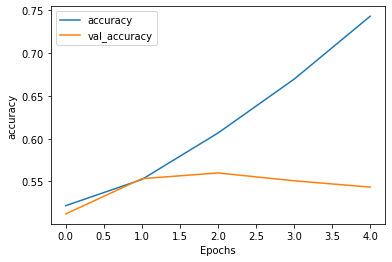

In [17]:
plot_graphs(history, 'accuracy')


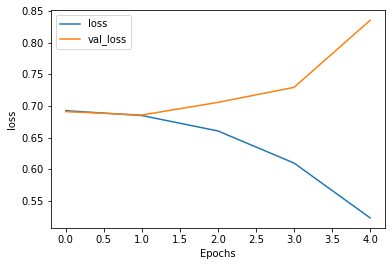

In [18]:
plot_graphs(history, 'loss')

## 모델 테스트

In [19]:
test_data.head()

,Unnamed: 0,articleid,mbti,title,content,menu_id,mbti_label,e_i,n_s,f_t,j_p
11142,41825,281699,enfp,동네친구 참 무섭네요ㅋㅋㅋㅋㅋㅋ,초중고 다녔던 지역에서 다른지역으로 3년정도 살았거든요그래서 다시 이쪽 지역으로 왔...,18,1,1,1,1,0
27004,9862,484473,entp,도대체 INFJ는 왜이리 ENTP을 좋아할까요? (엔팁 싫어하는 인프제도 찾아요),제 친구가 저를 유독 좋아하는데요 얘 왜이래 싶을정도로요 알고보니 친구는 infj였...,101,3,1,1,0,0
13019,22605,95167,enfj,우와...,전 솔직히 MBTI라는 걸 그냥 몇가지 정보만 아는 정도 였거든요 그런데 이번에 학...,14,0,1,1,1,1
4273,41728,288074,infp,(여우)<-바보,내일 섭센 갈 정도로 사고친건 아닌데 그냥 업글 겸 공초 부탁드리러 가려고요 역시 ...,18,9,0,1,1,0
292,7926,357941,infp,주인공에 엄청 몰입하시는 분들 있나요?,드라마 영화나 특히 소설 읽을 때 내가 주인공이 되고 싶고 괜히 대사 한 번 연기하...,101,9,0,1,1,0


In [20]:
# test_data = test_data[:50] # for test

test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['content',CLASSIFIER_TYPE]].values:
    test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

    tokens = [vocab[vocab.bos_token]]  
    tokens += pad_sequences([test_tokenized_text], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    test_data_sents.append(tokens)
    test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [21]:
print("num sents, labels {}, {}".format(len(test_data_sents), len(test_data_labels)))

num sents, labels 5584, 5584


In [22]:
with tf.device('/GPU:7'):
    cls_model.load_weights(checkpoint_path)

    results = cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)
    print("test loss, test acc: ", results)

6/6 [==============================] - 23s 4s/step - loss: 0.7042 - accuracy: 0.5578
test loss, test acc:  [0.7041749954223633, 0.5578438639640808]
